In [2]:
## Use Python libraries
from dotenv import load_dotenv
load_dotenv()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("LoanVisualization").getOrCreate()
import matplotlib.pyplot as plt

In [3]:
df=spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                      user=os.getenv("MYSQL_USER"),\
                                      password=os.getenv("MYSQL_PASS"),\
                                      url="jdbc:mysql://{}:3306/creditcard_capstone".format(os.getenv("MYSQL_HOST")),\
                                      dbtable="CDW_SAPP_loan_application").load()


In [4]:
# PySpark DataFrame can be converted to Python pandas DataFrame using a function toPandas()
pdf=df.toPandas()
pdf.head()

,Application_ID,Application_Status,Credit_History,Dependents,Education,Gender,Income,Married,Property_Area,Self_Employed
0,LP001002,Y,1,0,Graduate,Male,medium,No,Urban,No
1,LP001003,N,1,1,Graduate,Male,medium,Yes,Rural,No
2,LP001005,Y,1,0,Graduate,Male,low,Yes,Urban,Yes
3,LP001006,Y,1,0,Not Graduate,Male,low,Yes,Urban,No
4,LP001008,Y,1,0,Graduate,Male,medium,No,Urban,No


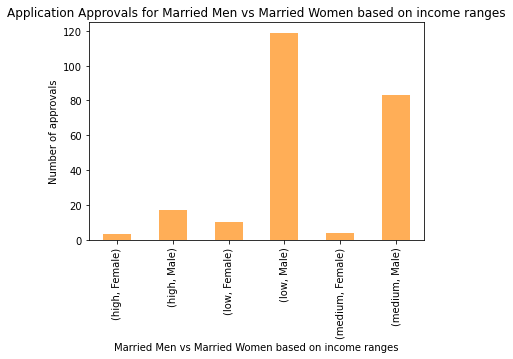

In [5]:
# Create a bar chart that shows the difference in application approvals for Married Men vs Married Women based on income ranges.
df_Married_Approved=pdf[(pdf["Application_Status"]=="Y")& (pdf["Married"]=="Yes")]
#df_Married_Approved.head()

dfg1=df_Married_Approved.groupby(['Income','Gender'])['Application_Status'].count()

dfg1.plot(kind='bar',color='#ffae57',xlabel='Married Men vs Married Women based on income ranges',ylabel='Number of approvals')
plt.title('Application Approvals for Married Men vs Married Women based on income ranges')
plt.show()

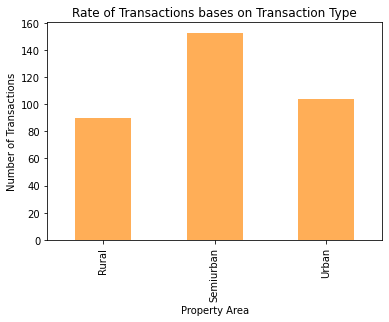

In [6]:
# Create and plot a chart that shows the difference in application approvals based on Property Area. 
df_Approved=pdf.query("Application_Status=='Y'")
dfg2=df_Approved.groupby(["Property_Area"])['Application_Status'].count()

dfg2.plot(kind='bar',color='#ffae57',xlabel='Property Area',ylabel='Number of Transactions')
plt.title('Rate of Transactions bases on Transaction Type')
plt.show()

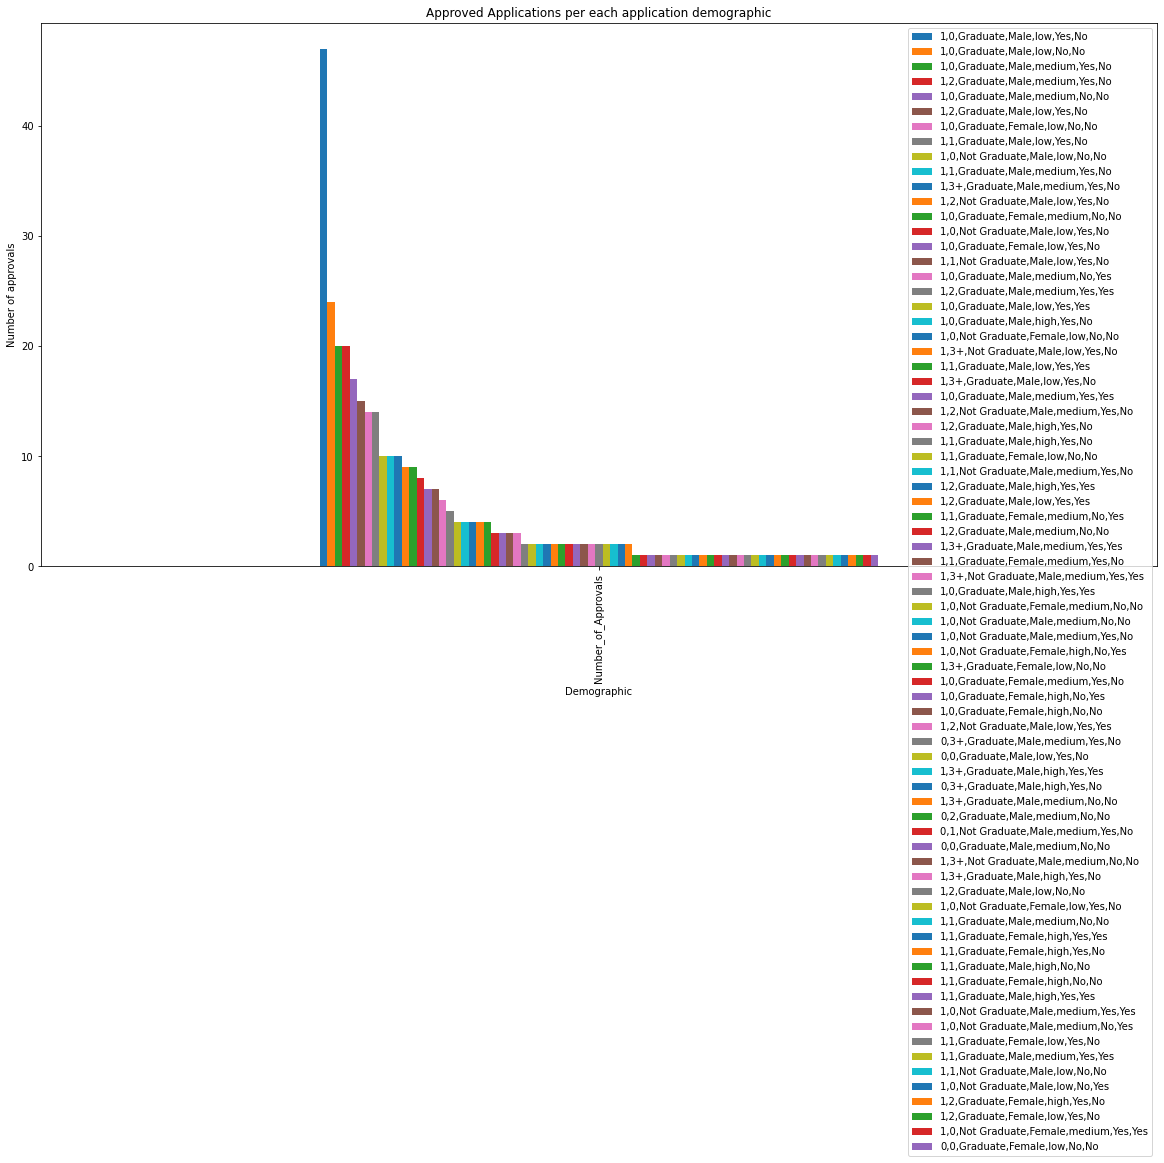

In [20]:
# Create a multi-line plot that shows the total number of approved applications per each application demographic. 
dfg_new=df_Approved.groupby(["Credit_History","Dependents","Education","Gender","Income","Married","Self_Employed"])["Application_Status"].count().reset_index()
#dfg_new=dfg_new.set_index("Income")
dfg_new["Demographic"]= dfg_new[dfg_new.columns[0:7]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
dfg_new=dfg_new.rename(columns={"Application_Status":"Number_of_Approvals"})
#dfg_new
dfg_final=dfg_new[["Demographic","Number_of_Approvals"]]
dfg_final=dfg_final.sort_values(by='Number_of_Approvals', ascending=False)
#dfg_final
dfg_final=dfg_final.set_index("Demographic")
dfg_transposed =dfg_final.transpose()
#dfg_transposed

dfg_transposed.plot(kind='bar',xlabel='Demographic',ylabel='Number of approvals',figsize=(20,10))
plt.title('Approved Applications per each application demographic')
plt.legend(loc='upper right')
plt.show()